In [1]:
#%% Import Moduels

## System Tools
from _Public import *

import seaborn as sns
import matplotlib.backends.backend_pdf as figpdf
import matplotlib.dates as matdates
import pyfixest as pf
from binsreg import binsreg

## Output Folder
OutputFolder = 'Micro_data/results/Analysis_EventStudy/'
if not os.path.exists(OutputFolder):
    os.makedirs(OutputFolder)
## Self-written Modules
import Toolkit_TimeSeries as MyTS
import Toolkit_Graphics as MyGR

In [2]:
import stata_setup
stata_setup.config("D:/Stata18/","mp")
from pystata import stata

OSError: [WinError -1066598274] Windows Error 0xc06d007e

# Construct the sample

## Load in the data

In [9]:
DataFolder          =   "Micro_data\\datasets\\SDC\\"
SDC_AccAbRet        =   pd.read_pickle(DataFolder+"SDC_AccAbRet.p")
SDC_IssuanceInfo    =   pd.read_pickle(DataFolder+"SDC_IssuanceInfo.p") 
SDC_AbRetPanel      =   pd.read_pickle(DataFolder+"SDC_AbRet_Panel.p")

In [10]:
SDC_RetPanel = pd.read_pickle(DataFolder+"SDC_Ret.p")

In [11]:
SDC_RetPanel.columns 

Index(['IssueID', 'FilingDate', 'LaunchDate', 'IssueDate', 'Date', 'Ret_NAdj',
       'Ret_Adj', 'DiffLogPrice', 'FDate_NAdj', 'FDate_Adj', 'LDate_NAdj',
       'LDate_Adj', 'IDate_NAdj', 'IDate_Adj', 'SpRet_NAdj', 'SpRet_Adj',
       'DiffLogSpIdx', 'rf_3m', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf',
       'umd', 'ExDiffLogPrice', 'ExDiffLogSpIdx', 'ExRet_NAdj', 'ExRet_Adj',
       'ExSpRet_NAdj', 'ExSpRet_Adj'],
      dtype='object')

## Clean the data

In [12]:
SamplePeriod  = (datetime.date(1985,1,1), datetime.date(2018,12,31))


In [13]:
# Sample restriction:
# 1. Sample period: 1985Q1-2018Q2
TempInd = (SDC_IssuanceInfo['IssueDate'] >= SamplePeriod[0]) & (SDC_IssuanceInfo['IssueDate'] <= SamplePeriod[1])
# 2. Only primary share offering 
TempInd = TempInd & (SDC_IssuanceInfo['ShareType']=='Primary')
# 3. Filing date has to be before the launch and issue date 
TempInd = TempInd & (SDC_IssuanceInfo['FilingDate'] <= SDC_IssuanceInfo['LaunchDate']) &\
          (SDC_IssuanceInfo['FilingDate'] <= SDC_IssuanceInfo['IssueDate'])




In [14]:
SDC_Sample = SDC_IssuanceInfo.loc[TempInd, :]

# Important statistics about the SDC sample

## Gap days between different types of event

### Unconditional distribution

In [15]:
TempList = [xx+yy for xx in ['GapDays_', 'GapBusDays_'] for yy in ['F2I', 'L2I', 'F2L']]
GapDayFreqTab_Detailed = pd.concat([SDC_Sample[vv].value_counts(normalize=True) for vv in TempList], join='outer', axis=1, keys=TempList).fillna(0).sort_index()

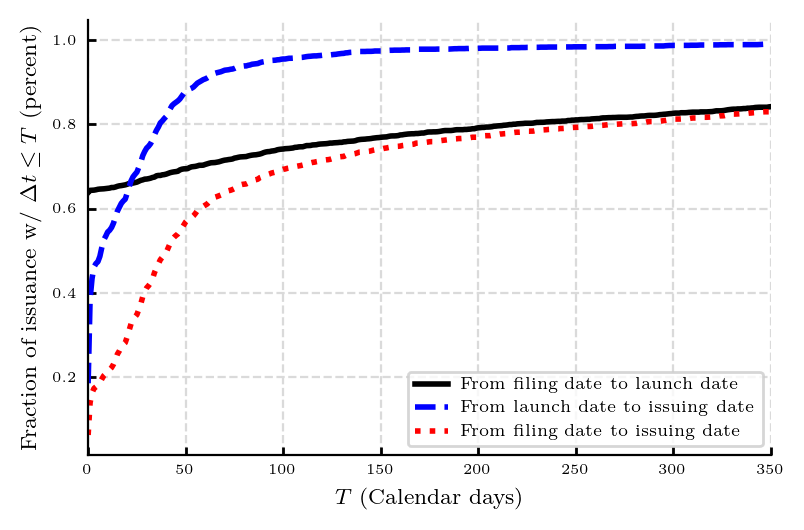

In [16]:
DataForPlot = GapDayFreqTab_Detailed.sort_index().cumsum()

Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Color="Black", Style="solid", Width=2).Plot(DataForPlot.index, DataForPlot['GapDays_F2L'], ax=ax, Label="From filing date to launch date")
MyGR.Line(Color="Blue", Style="dashed", Width=2).Plot(DataForPlot.index, DataForPlot['GapDays_L2I'], ax=ax, Label="From launch date to issuing date")
MyGR.Line(Color="Red", Style="dotted", Width=2).Plot(DataForPlot.index, DataForPlot['GapDays_F2I'], ax=ax, Label="From filing date to issuing date")
ax.set_xlim([0, 350])
ax.set_ylabel(r'Fraction of issuance w/ $\Delta t \leq T$ (percent)', fontsize=8) 
ax.set_xlabel(r'$T$ (Calendar days)', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.Setup_Ax(ax, XTickNbins=10, YTickNbins=10)
plt.legend(loc='lower right', fontsize=6)

plt.tight_layout()

plt.savefig(OutputFolder+'GapDays_CDF.eps', format='eps', dpi=1000)

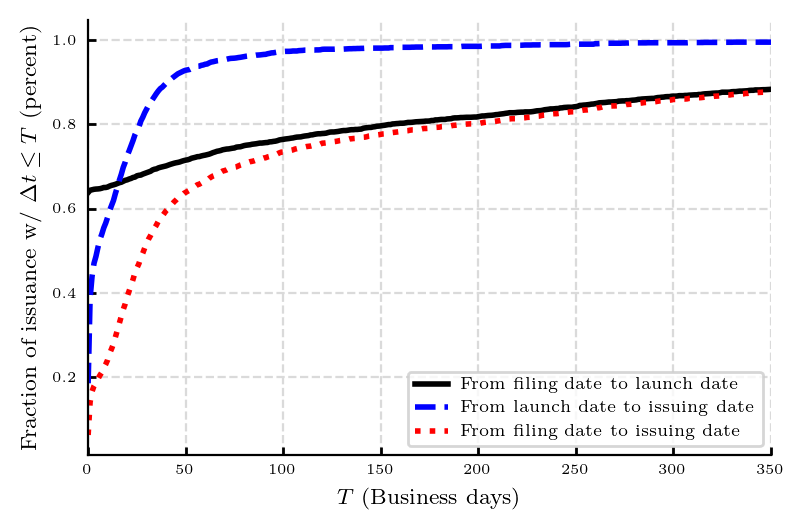

In [17]:
DataForPlot = GapDayFreqTab_Detailed.sort_index().cumsum()

Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Color="Black", Style="solid", Width=2).Plot(DataForPlot.index, DataForPlot['GapBusDays_F2L'], ax=ax, Label="From filing date to launch date")
MyGR.Line(Color="Blue", Style="dashed", Width=2).Plot(DataForPlot.index, DataForPlot['GapBusDays_L2I'], ax=ax, Label="From launch date to issuing date")
MyGR.Line(Color="Red", Style="dotted", Width=2).Plot(DataForPlot.index, DataForPlot['GapBusDays_F2I'], ax=ax, Label="From filing date to issuing date")
ax.set_xlim([0, 350])
ax.set_ylabel(r'Fraction of issuance w/ $\Delta t \leq T$ (percent)', fontsize=8) 
ax.set_xlabel(r'$T$ (Business days)', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.Setup_Ax(ax, XTickNbins=10, YTickNbins=10)
plt.legend(loc='lower right', fontsize=6)

plt.tight_layout()

plt.savefig(OutputFolder+'GapBusDays_CDF.eps', format='eps', dpi=1000)

In [18]:
DefaultCutoff = sorted(list(range(-5, 0, 1)) + list(range(0, 10, 1)) + list(range(10, 110, 10)) + [-np.inf, np.inf])
def KeyGapDayDistStat(df, CriticalValues=DefaultCutoff):
    temp = df.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    freq = pd.cut(df, bins=CriticalValues, right=False).value_counts(normalize=True).sort_index()
    return pd.concat([temp, freq], axis=0)

In [19]:
TempList = [xx+yy for xx in ['GapDays_', 'GapBusDays_'] for yy in ['F2L', 'L2I', 'F2I']]
Cutoff = sorted([0, 1, 5, 10, 30, 60, 180, 300] + [-np.inf, np.inf])
GapDayFreqTab = pd.concat([KeyGapDayDistStat(SDC_Sample[vv], CriticalValues=Cutoff) for vv in TempList], axis=1, join='outer', keys=TempList)

In [20]:
GapDayFreqTab 

,GapDays_F2L,GapDays_L2I,GapDays_F2I,GapBusDays_F2L,GapBusDays_L2I,GapBusDays_F2I
count,3533.000000,3533.000000,3533.000000,3533.000000,3533.000000,3533.000000
mean,141.111520,28.385225,169.496745,100.720917,20.388339,121.109256
std,296.763328,78.842125,294.930429,211.919228,56.275771,210.645711
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,15.000000,0.000000,1.000000,11.000000
50%,0.000000,7.000000,41.000000,0.000000,5.000000,29.000000
75%,115.000000,32.000000,163.000000,81.000000,23.000000,117.000000
90%,571.000000,57.800000,588.000000,407.400000,41.000000,420.000000
max,3584.000000,1321.000000,3598.000000,2560.000000,943.000000,2570.000000


In [21]:
GapDayFreqTab.to_latex(OutputFolder+'GapDays_DistStatTab.tex', float_format="%.3g", escape=True)


### Special features of shelf-registration issuance 

In [22]:
TempList = [xx+yy for xx in ['GapDays_', 'GapBusDays_'] for yy in ['F2I', 'L2I', 'F2L']]
GapDayFreqTab_Detailed = pd.concat([SDC_Sample.groupby('ShelfIssueFlag')[vv].value_counts(normalize=True) for vv in TempList], join='outer', axis=1, keys=TempList) \
                           .fillna(0).sort_index().unstack(level='ShelfIssueFlag').fillna(0).sort_index()

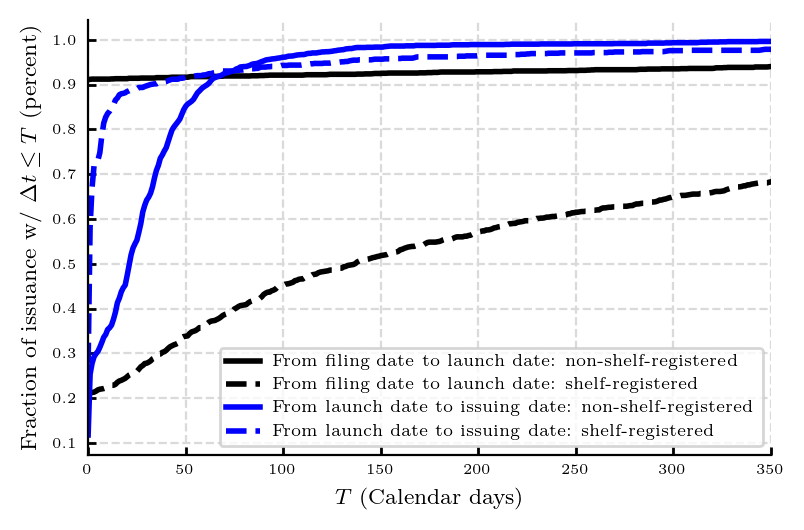

In [23]:
DataForPlot = GapDayFreqTab_Detailed.sort_index().cumsum()

Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Color="Black", Style="solid", Width=2).Plot(DataForPlot.index, DataForPlot[('GapDays_F2L', 0)], ax=ax, Label="From filing date to launch date: non-shelf-registered")
MyGR.Line(Color="Black", Style="dashed", Width=2).Plot(DataForPlot.index, DataForPlot[('GapDays_F2L', 1)], ax=ax, Label="From filing date to launch date: shelf-registered")
MyGR.Line(Color="Blue", Style="solid", Width=2).Plot(DataForPlot.index, DataForPlot[('GapDays_L2I', 0)], ax=ax, Label="From launch date to issuing date: non-shelf-registered")
MyGR.Line(Color="Blue", Style="dashed", Width=2).Plot(DataForPlot.index, DataForPlot[('GapDays_L2I', 1)], ax=ax, Label="From launch date to issuing date: shelf-registered")
ax.set_xlim([0, 350])
ax.set_ylabel(r'Fraction of issuance w/ $\Delta t \leq T$ (percent)', fontsize=8) 
ax.set_xlabel(r'$T$ (Calendar days)', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.Setup_Ax(ax, XTickNbins=10, YTickNbins=10)
plt.legend(loc='lower right', fontsize=6)

plt.tight_layout()

plt.savefig(OutputFolder+'GapDays_CDF_ShelfVsNonShelf.eps', format='eps', dpi=1000)

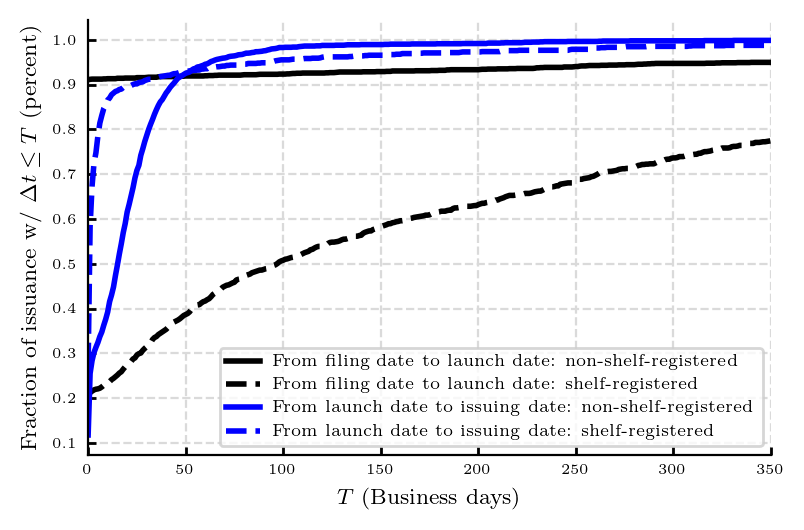

In [24]:
DataForPlot = GapDayFreqTab_Detailed.sort_index().cumsum()

Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Color="Black", Style="solid", Width=2).Plot(DataForPlot.index, DataForPlot[('GapBusDays_F2L', 0)], ax=ax, Label="From filing date to launch date: non-shelf-registered")
MyGR.Line(Color="Black", Style="dashed", Width=2).Plot(DataForPlot.index, DataForPlot[('GapBusDays_F2L', 1)], ax=ax, Label="From filing date to launch date: shelf-registered")
MyGR.Line(Color="Blue", Style="solid", Width=2).Plot(DataForPlot.index, DataForPlot[('GapBusDays_L2I', 0)], ax=ax, Label="From launch date to issuing date: non-shelf-registered")
MyGR.Line(Color="Blue", Style="dashed", Width=2).Plot(DataForPlot.index, DataForPlot[('GapBusDays_L2I', 1)], ax=ax, Label="From launch date to issuing date: shelf-registered")
ax.set_xlim([0, 350])
ax.set_ylabel(r'Fraction of issuance w/ $\Delta t \leq T$ (percent)', fontsize=8) 
ax.set_xlabel(r'$T$ (Business days)', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.Setup_Ax(ax, XTickNbins=10, YTickNbins=10)
plt.legend(loc='lower right', fontsize=6)

plt.tight_layout()

plt.savefig(OutputFolder+'GapBusDays_CDF_ShelfVsNonShelf.eps', format='eps', dpi=1000)

In [25]:
TempList = [xx+yy for xx in ['GapDays_', 'GapBusDays_'] for yy in ['F2L', 'L2I', 'F2I']]
Cutoff = sorted([0, 1, 5, 10, 30, 60, 180, 300] + [-np.inf, np.inf])
GapDayFreqTab = pd.concat([SDC_Sample.groupby('ShelfIssueFlag')[vv].apply(lambda x: KeyGapDayDistStat(x, CriticalValues=Cutoff)).unstack(level='ShelfIssueFlag') for vv in TempList], axis=1, join='outer', keys=TempList)

In [26]:
GapDayFreqTab

GapDays_F2L               GapDays_L2I               \
ShelfIssueFlag          0.0          1.0          0.0          1.0   
count           2141.000000  1362.000000  2141.000000  1362.000000   
mean              50.259692   287.034508    30.377861    25.821586   
std              195.938079   365.311122    52.954518   108.135666   
min                0.000000     0.000000     0.000000     0.000000   
10%                0.000000     0.000000     0.000000     0.000000   
25%                0.000000    21.000000     1.000000     0.000000   
50%                0.000000   137.000000    22.000000     1.000000   
75%                0.000000   443.500000    39.000000     7.000000   
90%                0.000000   779.800000    62.000000    32.000000   
max             2571.000000  3584.000000  1321.000000  1297.000000   
[-inf, 0.0)        0.000000     0.000000     0.000000     0.000000   
[0.0, 1.0)         0.910789     0.201175     0.118169     0.278267   
[1.0, 5.0)         0.001401     0.014684     0.181224     0.449339   
[5.0, 10.0)        0.000000     0.007342     0.042971     0.099853   
[10.0, 30.0)       0.002335     0.054332     0.288183     0.068282   
[30.0, 60.0)       0.003270     0.080764     0.263428     0.025698   
[60.0, 180.0)      0.009341     0.190896     0.093881     0.040382   
[180.0, 300.0)     0.007940     0.099119     0.005138     0.013950   
[300.0, inf)       0.064923     0.351689     0.007006     0.024229   

                GapDays_F2I              GapBusDays_F2L               \
ShelfIssueFlag          0.0          1.0            0.0          1.0   
count           2141.000000  1362.000000    2141.000000  1362.000000   
mean              80.637553   312.856094      35.887903   204.853891   
std              195.903296   363.025809     139.933504   260.903827   
min                0.000000     0.000000       0.000000     0.000000   
10%                1.000000     7.000000       0.000000     0.000000   
25%                8.000000    52.250000       0.000000    15.000000   
50%               27.000000   168.000000       0.000000    97.000000   
75%               48.000000   469.500000       0.000000   316.000000   
90%              129.000000   797.000000       0.000000   556.000000   
max             2572.000000  3598.000000    1837.000000  2560.000000   
[-inf, 0.0)        0.000000     0.000000       0.000000     0.000000   
[0.0, 1.0)         0.082672     0.016153       0.910789     0.201175   
[1.0, 5.0)         0.138253     0.077093       0.001401     0.019090   
[5.0, 10.0)        0.038767     0.017621       0.000467     0.008811   
[10.0, 30.0)       0.287249     0.055066       0.002802     0.082232   
[30.0, 60.0)       0.264830     0.105727       0.003737     0.104258   
[60.0, 180.0)      0.103223     0.238620       0.012144     0.199706   
[180.0, 300.0)     0.013078     0.111601       0.015880     0.120411   
[300.0, inf)       0.071929     0.378120       0.052779     0.264317   

               GapBusDays_L2I              GapBusDays_F2I               
ShelfIssueFlag            0.0          1.0            0.0          1.0  
count             2141.000000  1362.000000    2141.000000  1362.000000  
mean                21.762261    18.637298      57.650163   223.491189  
std                 37.762514    77.214687     139.918863   259.285703  
min                  0.000000     0.000000       0.000000     0.000000  
10%                  0.000000     0.000000       1.000000     5.000000  
25%                  1.000000     0.000000       6.000000    37.000000  
50%                 16.000000     1.000000      19.000000   120.000000  
75%                 28.000000     5.000000      34.000000   335.500000  
90%                 44.000000    23.000000      92.000000   569.000000  
max                943.000000   927.000000    1838.000000  2570.000000  
[-inf, 0.0)          0.000000     0.000000       0.000000     0.000000  
[0.0, 1.0)           0.118169     0.278267       0.082672     0.016153  
[1.0, 5.0)

In [27]:
GapDayFreqTab.to_latex(OutputFolder+'GapDays_DistStatTab_ShelfVsNonShelf.tex', float_format="%.3g", escape=True)

# Stock price movements 

In [28]:
def KeyRetStat(df):
    Num_Total = df.count()
    # Fraction of zero, positive, and negative values 
    Frac_0 = (df==0).sum()/Num_Total
    Frac_Pos = (df>0).sum()/Num_Total
    Frac_Neg = (df<0).sum()/Num_Total
    FracStat = pd.Series([Frac_0, Frac_Pos, Frac_Neg], index=['Frac_0', 'Frac_Pos', 'Frac_Neg'])
    # Mean, median, and standard deviation
    DescStat = df.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

    return pd.concat([FracStat, DescStat], axis=0)



## Generate the return panel 

In [29]:
TempVarList = ['IssueID', 'DiffLogPrice', ] + [xx+'Date_Adj' for xx in ['F', 'L', 'I']]
RetPanel = SDC_Sample.merge(SDC_RetPanel[TempVarList], on='IssueID', how='left').rename(columns={'DiffLogPrice': 'Ret', 'FDate_Adj': 'FDate', 'LDate_Adj': 'LDate', 'IDate_Adj': 'IDate'})

In [30]:
# Starting of the event window
RetPanel['EventDate'] = RetPanel['FDate']

TempInd = RetPanel['ShelfIssueFlag'] == 1
RetPanel.loc[TempInd, 'EventDate'] = RetPanel.loc[TempInd, 'LDate']

# Ending of the event window 
RetPanel['EventDate_End'] = RetPanel['GapBusDays_F2I']
RetPanel.loc[TempInd, 'EventDate_End'] = RetPanel.loc[TempInd, 'GapBusDays_L2I']


## Alternative measures for different types of event dates

We should look at three types of stock price changes for each event date:

1. Non-exclusive stock price change for each event date $t$: $\log(P_{t+1})- \log(P_{t-1})$;
2. Total stock price change from the starting event to the issue date: $\log(P_{t_{end}+1})-\log(P_{t_{start}-1})$
   * For non-shelf-registered issuance, the starting event is filing date
   * For shelf-registered issuance, the starting event is launch date
3. Exclusive stock price change for each event date:
   * For non-shelf-registered issuance, 
      * Filing date $t^{F}$: $\log(P_{t^{F}+1})- \log(P_{t^{F}-1})$
      * Launch date $t^{L}$: $\log(P_{t^{L}+1})- \log(\max\{P_{t^{L}-1}, P_{t^{F}+1} \})$
      * Issue date $t^{I}$: $\log(P_{t^{I}+1})- \log(\max\{P_{t^{I}-1}, P_{t^{L}+1} \})$
   * For shelf-registered issuance,
      * Filing date $t^{F}$: N.A. if $t^{F}<t^{L}-1$ else $\log(P_{t^{F}+1})- \log(P_{t^{L}-1})$   
      * Launch date $t^{L}$: $\log(P_{t^{L}+1})- \log(\max\{P_{t^{L}-1}, P_{t^{F}+1} \})$
      * Issue date $t^{I}$: $\log(P_{t^{I}+1})- \log(\max\{P_{t^{I}-1}, P_{t^{L}+1} \})$

In [31]:
def PriceChange_ByEventDate_NonExclusive(df, DateWindow=(-1, 1)):
    PriceChange = pd.Series([df.loc[(df[xx+'Date']>DateWindow[0]) & (df[xx+'Date']<=DateWindow[1]) , 'Ret'].sum() \
                             for xx in ['F', 'L', 'I']], index=['F', 'L', 'I'])
    return PriceChange

def PriceChange_WithinEventWindow_Total(df, DateWindow=(-1, 1)):
    return df.loc[(df['EventDate']>DateWindow[0]) & (df['EventDate']<=df['EventDate_End']+DateWindow[1]) , 'Ret'].sum()

def PriceChange_WithinEventWindow_First(df, DateWindow=(-1, 1)):
    return df.loc[(df['EventDate']>DateWindow[0]) & (df['EventDate']<=DateWindow[1]) , 'Ret'].sum()

def PriceChange_WithinEventWindow_ByEventDate_Exclusive(df, DateWindow=(-1, 1)):
    TempDict = {}
    for ET  in ['F', 'L', 'I']:
        if ET == 'F':
            tempind = (df[ET+'Date']>=DateWindow[0]) & (df[ET+'Date']<=DateWindow[1])
            Date_1 = df.loc[tempind, 'EventDate'].min()
            Date_2 = df.loc[tempind, 'EventDate'].max()

            Date_1 = max(Date_1, DateWindow[0])
            Date_2 = min(Date_2, df['EventDate_End'].values[0] + DateWindow[1])

            tempind = (df['EventDate']>Date_1) & (df['EventDate']<=Date_2)

            TempDict[ET] = df.loc[tempind, 'Ret'].sum() if tempind.sum()>0 else np.nan 

            Date_2_pre = Date_2
        else:
            tempind = (df[ET+'Date']>=DateWindow[0]) & (df[ET+'Date']<=DateWindow[1])
            Date_1 = df.loc[tempind, 'EventDate'].min()
            Date_2 = df.loc[tempind, 'EventDate'].max()

            Date_1 = max(Date_1, Date_2_pre)
            Date_2 = min(Date_2, df['EventDate_End'].values[0] + DateWindow[1])

            tempind = (df['EventDate']>Date_1) & (df['EventDate']<=Date_2)

            TempDict[ET] = df.loc[tempind, 'Ret'].sum() if tempind.sum()>0 else np.nan

            Date_2_pre = Date_2

    return pd.Series(TempDict)

In [32]:
PriceChange_NonExcl = RetPanel.groupby('IssueID').apply(PriceChange_ByEventDate_NonExclusive, include_groups=False)

array([[<Axes: title={'center': 'F'}>, <Axes: title={'center': 'L'}>],
       [<Axes: title={'center': 'I'}>, <Axes: >]], dtype=object)

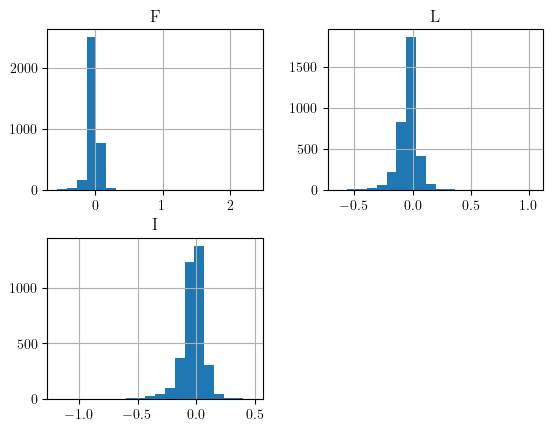

In [33]:
PriceChange_NonExcl.hist(bins=20)

In [34]:
PriceChange_Runup = RetPanel.groupby('IssueID').apply(lambda x: PriceChange_WithinEventWindow_Total(x, DateWindow=(-91, -1)), include_groups=False)

In [35]:
PriceChange_Total = RetPanel.groupby('IssueID').apply(PriceChange_WithinEventWindow_Total, include_groups=False)

In [36]:
PriceChange_First = RetPanel.groupby('IssueID').apply(PriceChange_WithinEventWindow_First, include_groups=False)

<Axes: >

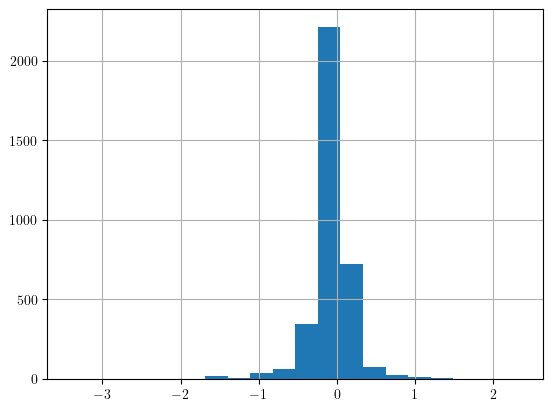

In [37]:
PriceChange_Total.hist(bins=20)

In [38]:
PriceChange_Excl = RetPanel.groupby('IssueID').apply(PriceChange_WithinEventWindow_ByEventDate_Exclusive, include_groups=False)

array([[<Axes: title={'center': 'F'}>, <Axes: title={'center': 'L'}>],
       [<Axes: title={'center': 'I'}>, <Axes: >]], dtype=object)

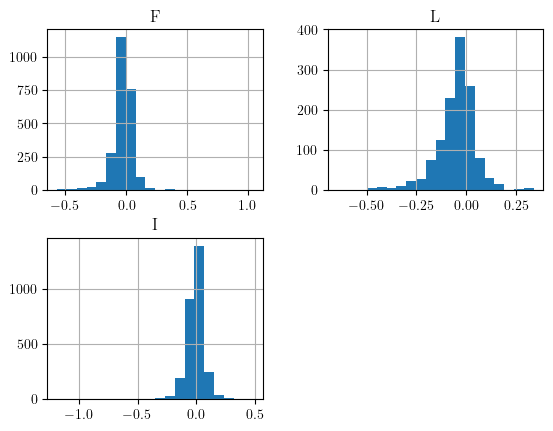

In [39]:
PriceChange_Excl.hist(bins=20)

In [40]:
PriceChange = pd.concat([PriceChange_NonExcl.rename(columns={'F': 'PC_NonExcl_F', 'L': 'PC_NonExcl_L', 'I': 'PC_NonExcl_I'}), \
                         PriceChange_Total.rename('PC_Total'), PriceChange_First.rename('PC_FirstEvent'), \
                         PriceChange_Runup.rename('PC_Runup'), \
                         PriceChange_Excl.rename(columns={'F': 'PC_Excl_F', 'L': 'PC_Excl_L', 'I': 'PC_Excl_I'})], axis=1, join='outer')

In [41]:
PriceChange.apply(KeyRetStat)

,PC_NonExcl_F,PC_NonExcl_L,PC_NonExcl_I,PC_Total,PC_FirstEvent,PC_Runup,PC_Excl_F,PC_Excl_L,PC_Excl_I
Frac_0,0.052363,0.046703,0.045570,0.021795,0.049250,0.016983,0.049669,0.005486,0.048342
Frac_Pos,0.332295,0.275120,0.367676,0.352958,0.283612,0.698556,0.295530,0.261755,0.441073
Frac_Neg,0.615341,0.678177,0.586753,0.625248,0.667138,0.284461,0.654801,0.732759,0.510586
count,3533.000000,3533.000000,3533.000000,3533.000000,3533.000000,3533.000000,2416.000000,1276.000000,2834.000000
mean,-0.021591,-0.036616,-0.027419,-0.060873,-0.033466,0.200874,-0.028477,-0.050791,-0.008948
std,0.093254,0.095426,0.103303,0.281790,0.091266,0.517043,0.089545,0.098016,0.087174
min,-0.567984,-0.645193,-1.184970,-3.416101,-0.567984,-3.220123,-0.567984,-0.645193,-1.184970
1%,-0.295287,-0.353996,-0.362961,-0.980077,-0.344738,-1.276271,-0.343222,-0.390559,-0.253425
10%,-0.101292,-0.135006,-0.130028,-0.294754,-0.126721,-0.314396,-0.110517,-0.164294,-0.090077
25%,-0.054377,-0.072676,-0.066140,-0.136116,-0.068025,-0.038221,-0.061629,-0.093222,-0.040816


In [42]:
PriceChange.corr()

,PC_NonExcl_F,PC_NonExcl_L,PC_NonExcl_I,PC_Total,PC_FirstEvent,PC_Runup,PC_Excl_F,PC_Excl_L,PC_Excl_I
PC_NonExcl_F,1.000000,0.634466,0.225072,0.241211,0.690794,0.093712,0.978651,0.080438,0.022631
PC_NonExcl_L,0.634466,1.000000,0.475269,0.387913,0.925327,0.148431,0.874220,0.992970,0.015822
PC_NonExcl_I,0.225072,0.475269,1.000000,0.358195,0.402298,0.011210,0.290300,0.726368,0.841375
PC_Total,0.241211,0.387913,0.358195,1.000000,0.333664,0.461538,0.287648,0.409163,0.257014
PC_FirstEvent,0.690794,0.925327,0.402298,0.333664,1.000000,0.112642,0.978381,0.791324,0.012378
PC_Runup,0.093712,0.148431,0.011210,0.461538,0.112642,1.000000,0.142243,0.153558,-0.038731
PC_Excl_F,0.978651,0.874220,0.290300,0.287648,0.978381,0.142243,1.000000,0.092744,0.011851
PC_Excl_L,0.080438,0.992970,0.726368,0.409163,0.791324,0.153558,0.092744,1.000000,0.035113
PC_Excl_I,0.022631,0.015822,0.841375,0.257014,0.012378,-0.038731,0.011851,0.035113,1.000000


In [43]:
PriceChange = SDC_Sample.merge(PriceChange.reset_index(), on='IssueID', how='left')

## Analysis of different types of price changes

### Summary statistics of Non-exclusive total returns associated with each date

In [44]:
PriceChange['Overlap_FL'] = (PriceChange['GapBusDays_F2L']<=1) * 1
PriceChange['Overlap_LI'] = (PriceChange['GapBusDays_L2I']<=1) * 1

In [45]:
TempList = ['PC_NonExcl_'+vv for vv in ['F', 'L', 'I']]
PC_NonExcl_Stat = pd.concat([PriceChange.groupby(['ShelfIssueFlag', 'Overlap_FL', 'Overlap_LI'])[vv] \
                            .apply(lambda x: KeyRetStat(x)).unstack(level=-1) for vv in TempList], \
                            axis=1, join='outer', keys=TempList).sort_index(axis=1)


In [46]:
PC_NonExcl_MainStat = PC_NonExcl_Stat.loc[:, idx[:, ['count', 'mean', '50%']]].sort_index(axis=1) \
                                     .loc[:, idx[['PC_NonExcl_'+vv for vv in ['F', 'L', 'I']],:]]

In [47]:
PC_NonExcl_MainStat

PC_NonExcl_F                    \
                                              50%   count      mean   
ShelfIssueFlag Overlap_FL Overlap_LI                                  
0.0            0          0             -0.013744    37.0 -0.029796   
                          1             -0.009303   152.0 -0.020526   
               1          0             -0.018576  1557.0 -0.024478   
                          1             -0.047964   395.0 -0.049578   
1.0            0          0             -0.000905   357.0 -0.002588   
                          1             -0.007128   714.0 -0.009377   
               1          0             -0.017250   210.0 -0.018667   
                          1             -0.038250    81.0 -0.036127   

                                     PC_NonExcl_L                    \
                                              50%   count      mean   
ShelfIssueFlag Overlap_FL Overlap_LI                                  
0.0            0          0             -0.045672    37.0 -0.067864   
                          1             -0.059868   152.0 -0.081425   
               1          0             -0.018588  1557.0 -0.024495   
                          1             -0.048253   395.0 -0.050684   
1.0            0          0             -0.027548   357.0 -0.037668   
                          1             -0.039132   714.0 -0.050542   
               1          0             -0.016932   210.0 -0.019166   
                          1             -0.039170    81.0 -0.035338   

                                     PC_NonExcl_I                    
                                              50%   count      mean  
ShelfIssueFlag Overlap_FL Overlap_LI                                 
0.0            0          0             -0.017858    37.0 -0.010132  
                          1             -0.043705   152.0 -0.073266  
               1          0             -0.001797  1557.0 -0.012854  
                          1             -0.044494   395.0 -0.059707  
1.0            0          0             -0.004000   357.0 -0.005190  
                          1             -0.036709   714.0 -0.047334  
               1          0             -0.010726   210.0 -0.019169  
                          1             -0.034871    81.0 -0.028460

### Share of total returns associated with event dates within the total returns over the whole event 

In [48]:
PriceChange['PC_Total_Event'] = PriceChange[['PC_Excl_'+vv for vv in ['F', 'L', 'I']]].sum(axis=1)
PriceChange['PC_Total_Event_Share'] = PriceChange['PC_Total_Event'] / PriceChange['PC_Total']

In [49]:
PriceChange.groupby('ShelfIssueFlag')['PC_Total_Event'].apply(KeyRetStat).unstack(level='ShelfIssueFlag')

ShelfIssueFlag,0.0,1.0
Frac_0,0.025689,0.006608
Frac_Pos,0.323213,0.323789
Frac_Neg,0.651098,0.669604
count,2141.000000,1362.000000
mean,-0.045568,-0.045090
std,0.136798,0.101878
min,-1.417302,-0.690400
1%,-0.482682,-0.358690
10%,-0.178809,-0.166088
25%,-0.095905,-0.093784


In [50]:
PriceChange.groupby('ShelfIssueFlag')['PC_FirstEvent'].apply(KeyRetStat).unstack(level='ShelfIssueFlag')

ShelfIssueFlag,0.0,1.0
Frac_0,0.071462,0.011747
Frac_Pos,0.279309,0.287078
Frac_Neg,0.649229,0.701175
count,2141.000000,1362.000000
mean,-0.028920,-0.041425
std,0.093882,0.085586
min,-0.567984,-0.437801
1%,-0.352374,-0.337168
10%,-0.112212,-0.141734
25%,-0.061608,-0.081707


In [51]:
PriceChange['s_Share'] = PriceChange['OfferedTotalShares'] / PriceChange['TotalShares_BeforeOffering']
PriceChange['s_Funding'] = PriceChange['ProceedsAmount'] / PriceChange['MarketValue']
PriceChange['LogK'] = np.log(PriceChange['TotalAsset_BeforeOffering'])
PriceChange['LogMV'] = np.log(PriceChange['MarketValue'])
PriceChange['LogProceeds'] = np.log(PriceChange['ProceedsAmount'])

C:\Users\guoxi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log


In [52]:
from binsreg import *

In [53]:
PriceChange[['PC_Total_Event', 's_Share', 's_Funding']].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,PC_Total_Event,s_Share,s_Funding
count,3533.000000,3411.000000,3405.000000
mean,-0.044996,18.435262,0.228983
std,0.124416,982.017991,1.050107
min,-1.417302,0.000000,0.000016
1%,-0.433711,0.013844,0.014423
10%,-0.173491,0.057228,0.055638
25%,-0.095002,0.093640,0.088899
50%,-0.031856,0.148774,0.141440
75%,0.018019,0.227240,0.214772
90%,0.071974,0.363495,0.342399


In [54]:
tempind = (PriceChange['PC_Total_Event']>-0.5) & (PriceChange['PC_Total_Event']<0.5) & (PriceChange['s_Share'].between(0, 2, inclusive='right')) 

In [65]:
est.data_plot[0]

In [68]:
bins = binsregselect('PC_Total_Event', 's_Share', data=PriceChange.loc[tempind, :], savegrid=True)

In [69]:
bins.data_grid

,s_Share,binreg_bin,binsreg_isknot
0,0.001968,0.0,0.0
1,0.003921,0.0,0.0
2,0.005873,0.0,0.0
3,0.007826,0.0,0.0
4,0.009778,0.0,0.0
...,...,...,...
393,1.642214,18.0,0.0
394,1.713772,18.0,0.0
395,1.785329,18.0,0.0
396,1.856886,18.0,0.0


In [74]:
est.imse_b_dpi

array([0.01119227])

In [76]:
result = est.data_plot[0]

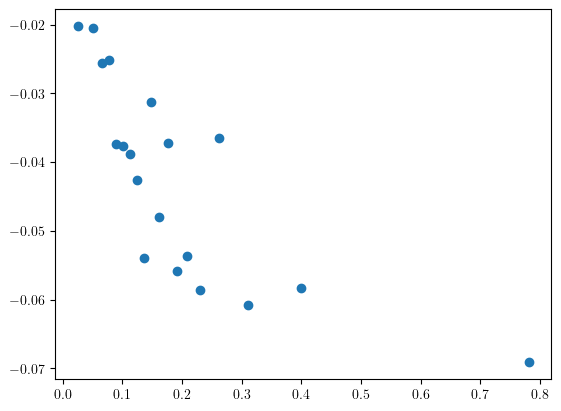

In [79]:
plt.scatter(result.dots['x'], result.dots['fit'])

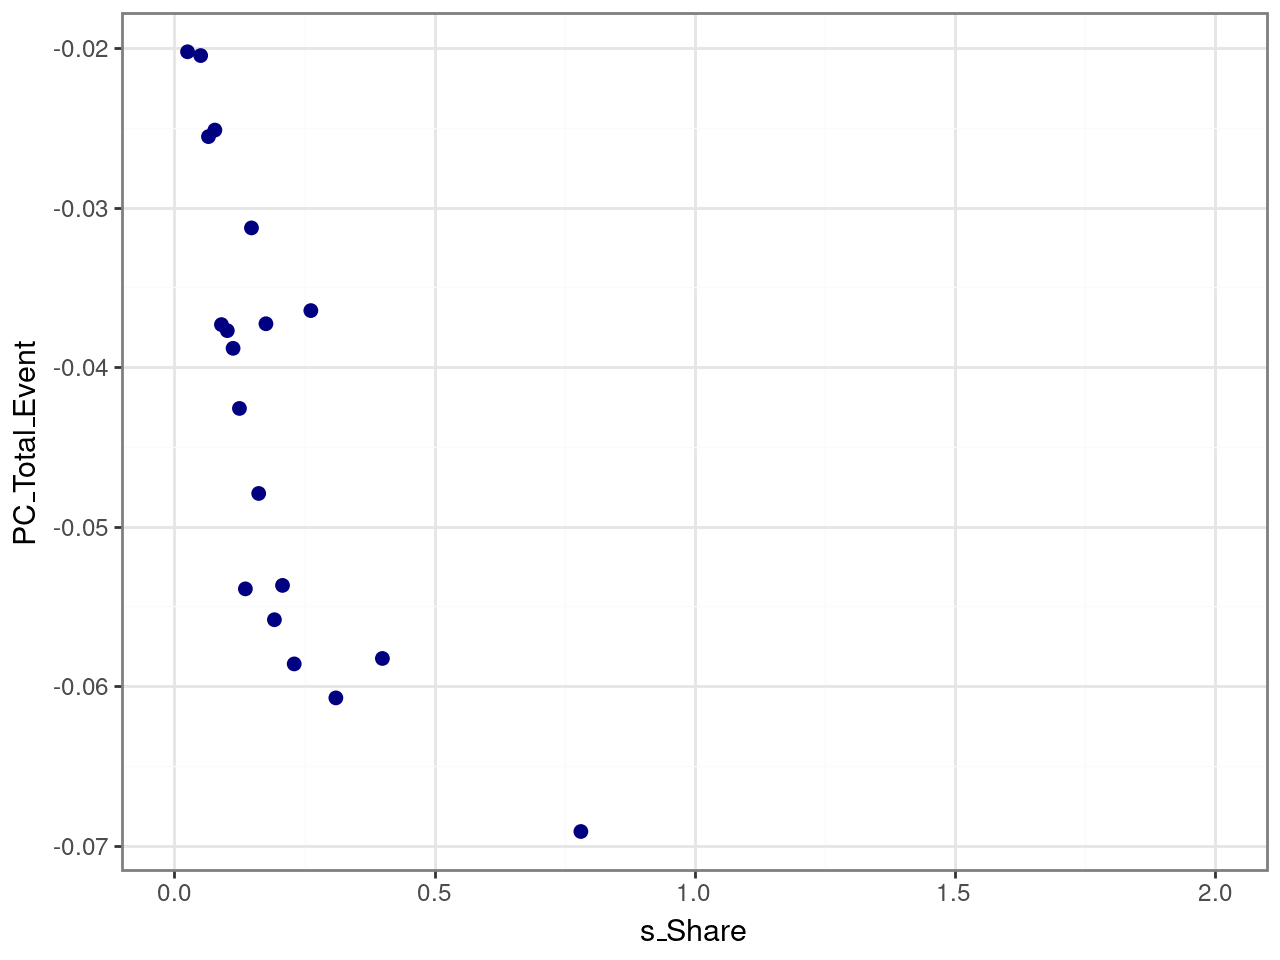

In [90]:
est = binsreg('PC_Total_Event', 's_Share',  data=PriceChange.loc[tempind, :])


In [98]:
sm.OLS(PriceChange.loc[tempind, 'PC_Total_Event'], PriceChange.loc[tempind, 's_Share']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         PC_Total_Event   R-squared (uncentered):                   0.108
Model:                            OLS   Adj. R-squared (uncentered):              0.108
Method:                 Least Squares   F-statistic:                              406.6
Date:                Wed, 14 May 2025   Prob (F-statistic):                    1.91e-85
Time:                        22:58:43   Log-Likelihood:                          2687.6
No. Observations:                3356   AIC:                                     -5373.
Df Residuals:                    3355   BIC:                                     -5367.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
s_Share       -0.1429      0.007    -20.164      0.000      -0.157      -0.129
==============================================================================
Omnibus:                      226.526   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              632.926
Skew:                          -0.357   Prob(JB):                    3.65e-138
Kurtosis:                       5.004   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
sm.OLS(est.data_plot[0].dots['fit'], est.data_plot[0].dots['x']).fit().summary()

C:\Users\guoxi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    fit   R-squared (uncentered):                   0.713
Model:                            OLS   Adj. R-squared (uncentered):              0.697
Method:                 Least Squares   F-statistic:                              44.80
Date:                Wed, 14 May 2025   Prob (F-statistic):                    2.81e-06
Time:                        22:57:46   Log-Likelihood:                          48.443
No. Observations:                  19   AIC:                                     -94.89
Df Residuals:                      18   BIC:                                     -93.94
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x             -0.1174      0.018     -6.694      0.000      -0.154      -0.081
==============================================================================
Omnibus:                       27.390   Durbin-Watson:                   0.318
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.698
Skew:                           2.371   Prob(JB):                     1.97e-10
Kurtosis:                       8.828   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

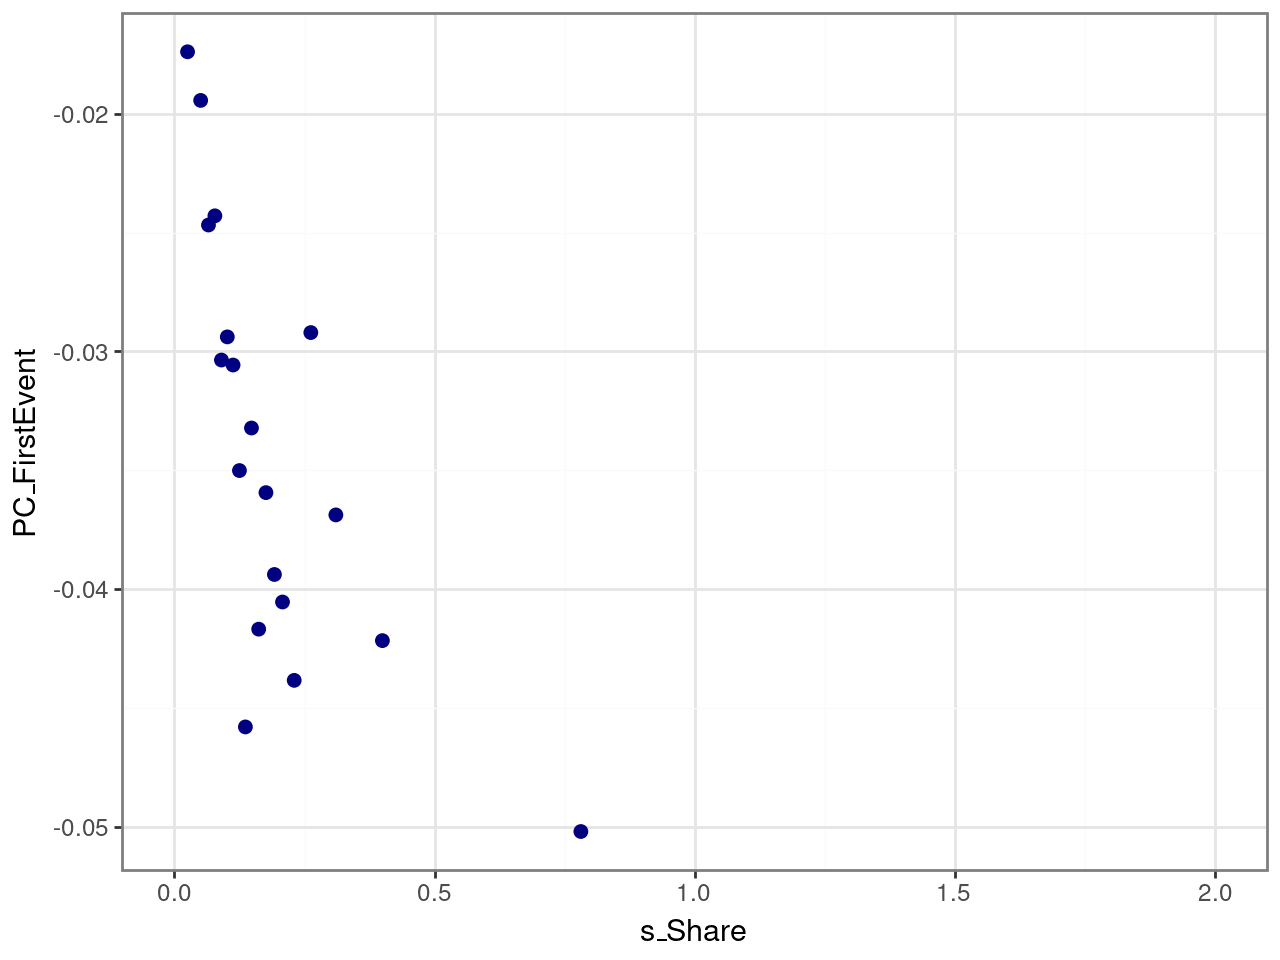

In [91]:
est = binsreg('PC_FirstEvent', 's_Share',  data=PriceChange.loc[tempind, :])

In [74]:
for cc in PriceChange.columns:
    if PriceChange[cc].dtype == 'float64':
        PriceChange.loc[~np.isfinite(PriceChange[cc]), cc] = np.nan 

In [ ]:
object_cols = PriceChange.select_dtypes(include=['object']).columns
for col in object_cols:
    if PriceChange[col].isnull().all():
        PriceChange[col] = PriceChange[col].astype(str)  # or drop it
    else:
        PriceChange[col] = PriceChange[col].astype(str)

In [77]:
PriceChange.to_stata(OutputFolder+'PriceChange.dta')

In [78]:
TempDS = PriceChange 

In [87]:
from scipy.stats import linregress

In [94]:
tempind = (TempDS['s_Share'] < 1) & (TempDS['s_Share']>0) & (np.abs(TempDS['PC_Total_Event'])<1)
TempDS = TempDS.loc[tempind, :]

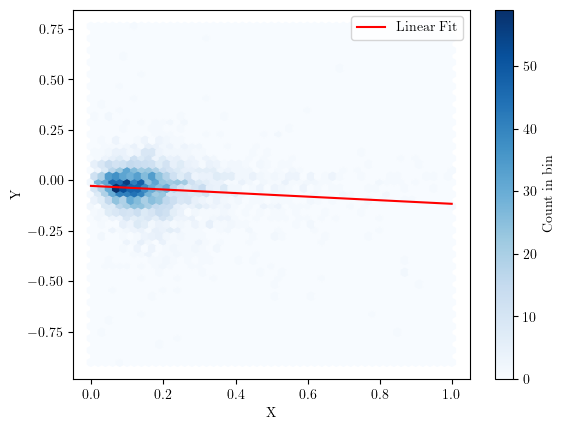

In [95]:
plt.hexbin(TempDS['s_Share'], TempDS['PC_Total_Event'], gridsize=50, cmap='Blues')
cb = plt.colorbar(label='Count in bin')

# Add regression line
slope, intercept, r_value, p_value, std_err = linregress(TempDS['s_Share'], TempDS['PC_Total_Event'])
x_vals = np.linspace(TempDS['s_Share'].min(), TempDS['s_Share'].max(), 100)
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', label='Linear Fit')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [96]:
TempDS['s_Share'].describe()

count    3342.000000
mean        0.181409
std         0.140264
min         0.000015
25%         0.092775
50%         0.146754
75%         0.220257
max         0.998310
Name: s_Share, dtype: float64

In [97]:
tempind = (TempDS['s_Share'] < 1) & (TempDS['s_Share']>0)
fit = pf.feols("PC_Total_Event ~ s_Share + LogProceeds + LogK + Leverage_BeforeOffering| IssueDate_Quarter + ShelfIssueFlag + FF10_Code", data=TempDS.loc[tempind, :])

In [98]:
fit.summary() 

###

Estimation:  OLS
Dep. var.: PC_Total_Event, Fixed effects: IssueDate_Quarter+ShelfIssueFlag+FF10_Code
Inference:  CRV1
Observations:  2006

| Coefficient             |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| s_Share                 |     -0.111 |        0.029 |    -3.768 |      0.000 | -0.169 |  -0.053 |
| LogProceeds             |      0.013 |        0.004 |     2.962 |      0.004 |  0.004 |   0.022 |
| LogK                    |     -0.007 |        0.003 |    -2.319 |      0.022 | -0.013 |  -0.001 |
| Leverage_BeforeOffering |     -0.000 |        0.000 |    -1.686 |      0.094 | -0.001 |   0.000 |
---
RMSE: 0.105 R2: 0.108 R2 Within: 0.025 


In [83]:
fit = pf.feols("PC_FirstEvent ~ s_Share + LogProceeds + LogK + Leverage_BeforeOffering + PC_Runup| IssueDate_Quarter + ShelfIssueFlag + FF10_Code", data=TempDS.loc[tempind, :])

In [84]:
fit.summary() 

###

Estimation:  OLS
Dep. var.: PC_FirstEvent, Fixed effects: IssueDate_Quarter+ShelfIssueFlag+FF10_Code
Inference:  CRV1
Observations:  2007

| Coefficient             |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| s_Share                 |     -0.048 |        0.021 |    -2.283 |      0.024 | -0.090 |  -0.006 |
| LogProceeds             |      0.007 |        0.003 |     2.024 |      0.045 |  0.000 |   0.014 |
| LogK                    |     -0.003 |        0.002 |    -1.387 |      0.168 | -0.007 |   0.001 |
| Leverage_BeforeOffering |     -0.000 |        0.000 |    -0.318 |      0.751 | -0.000 |   0.000 |
| PC_Runup                |      0.017 |        0.005 |     3.547 |      0.001 |  0.008 |   0.026 |
---
RMSE: 0.076 R2: 0.128 R2 Within: 0.025 


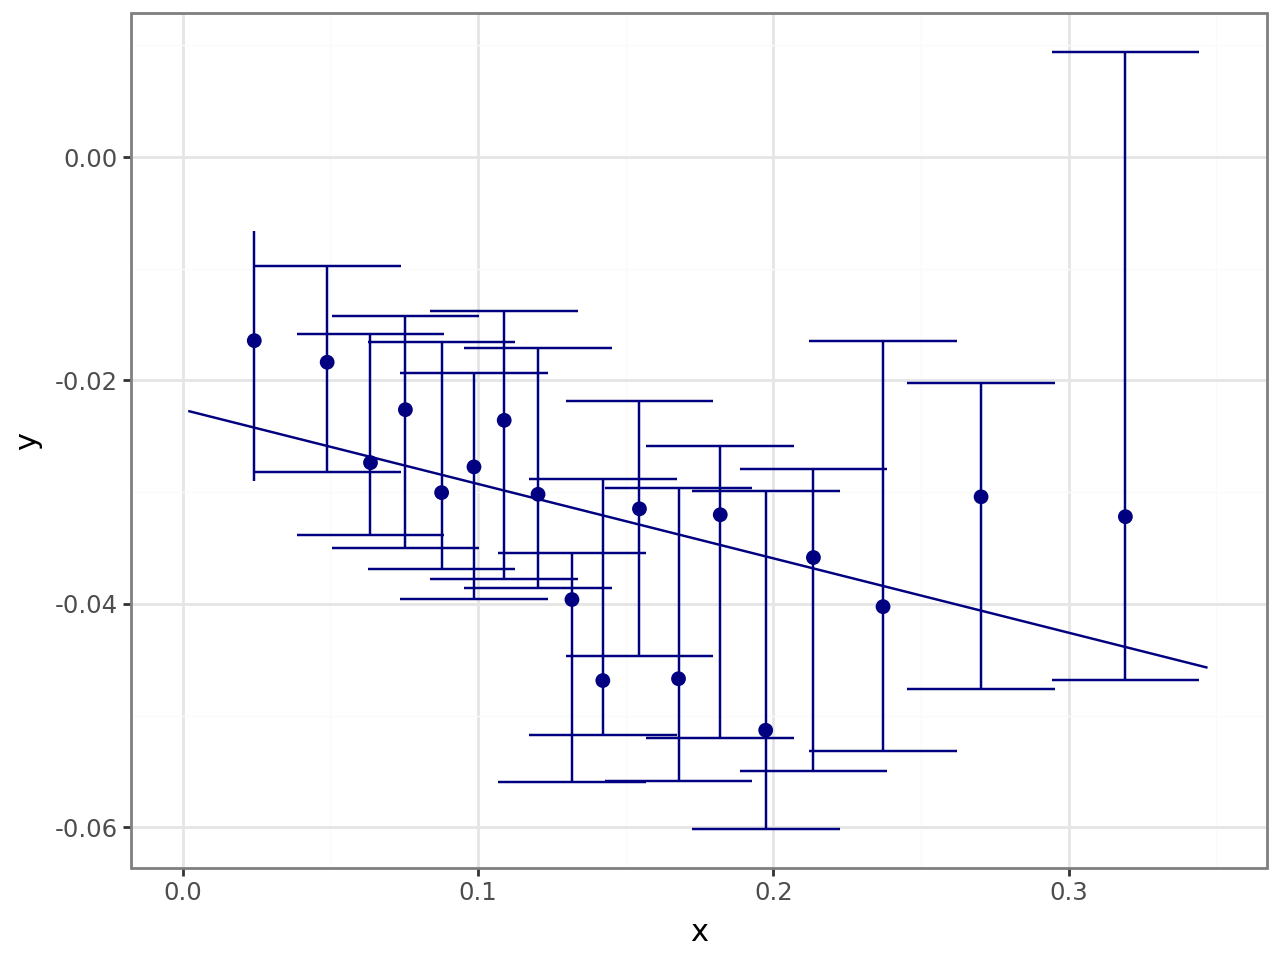

Call: binsreg

Binscatter Plot
Bin/Degree selection method (binsmethod) =  IMSE direct plug-in (select # of bins)
Placement (binspos)                      =                         Quantile-spaced
Derivative (deriv)                       =                                       0
 
Group (by)                               =                             Full Sample
Sample size (n)                          =                                    3041
# of distinct values (Ndist)             =                                    3040
# of clusters (Nclust)                   =                                     nan
dots, degree (p)                         =                                       0
dots, smooth (s)                         =                                       0
# of bins (nbins)                        =                                      18




In [103]:
binsreg(TempDS.loc[tempind, 'PC_FirstEvent'], TempDS.loc[tempind, 's_Share'], ci=(3,3), polyreg=1)

## Event study of stock price

In [ ]:
def GenRetPanel(RegDesignLabel):
    # 1. Extract the return history
    TempRet = SDC_AbRetPanel[RegDesignLabel].copy().sort_index()
    TempRet.columns = ['_'.join(vv) for vv in TempRet.columns]
    TempAccRet = TempRet.groupby('IssueID').cumsum().rename(columns=lambda x: x.replace('_', '_Acc'))
    TempAccRet = TempAccRet - TempAccRet.loc[idx[:, -1], :].reset_index(level='RelDate', drop=True)
    temp = pd.concat([TempRet, TempAccRet], axis=1, join='outer').sort_index()
    # 2. Merge with the issuance information
    TempVarList = ['IssueID', 'ShelfIssueFlag'] + ['GapBusDays_F2I', 'GapBusDays_L2I', 'GapBusDays_F2L']
    TempDS = SDC_Sample[TempVarList].merge(temp.reset_index(), on='IssueID', how='left')
    # 3. Assign the event date type based on shelf-registration type
    for vv in ['Ret', 'AbRet', 'AccRet', 'AccAbRet']:
        TempDS[vv] = TempDS['F_'+vv]
        TempDS.loc[TempDS['ShelfIssueFlag']==1, vv] = TempDS.loc[TempDS['ShelfIssueFlag']==1, 'L_'+vv]
    # Compute the statistics by relative date 
    TempVarList = ['Ret', 'AbRet']
    TempStat_Ret = pd.concat([TempDS.groupby('RelDate')[vv].apply(lambda x: KeyRetStat(x)) for vv in TempVarList], axis=1, join='outer', keys=TempVarList).unstack(level=1)

    TempVarList = ['AccRet', 'AccAbRet']
    TempStat_AccRet = pd.concat([TempDS.groupby('RelDate')[vv].apply(lambda x: KeyRetStat(x)) for vv in TempVarList], axis=1, join='outer', keys=TempVarList).unstack(level=1)

    TempStat = pd.concat([TempStat_Ret, TempStat_AccRet], axis=1, join='outer')

    return TempDS, TempStat

### Summary statistics

In [24]:
TempDS, TempStat = GenRetPanel('FF5_PreEvent')

In [17]:
# Kep percentile for the daily return 
def EventPlot_Lines(data, LineDict):
    Fig = MyGR.Setup_Fig()
    ax = Fig.add_subplot(1,1,1)
    for key, value in LineDict.items():
        MyGR.Line(Color=value['color'], Style=value['style'], Width=1).Plot(data.index, data[key]*value['scale'], ax=ax, Label=value['label'])
    
    ax.set_xlim([data.index[0], data.index[-1]])
    ax.set_ylabel(r'Percent', fontsize=8) 
    ax.set_xlabel(r'Business days relative to the event date', fontsize=8)
    ax.tick_params(axis='both', labelsize=5)
    MyGR.Setup_Ax(ax, XTickNbins=10, YTickNbins=10, Benchmark_X=0)
    plt.legend(loc='best', fontsize=6)

    plt.tight_layout()

    return Fig, ax

In [18]:
LineDict = \
    {'mean': {'style': 'solid', 'color': MyGR.MyColor('Black'), 'label': "Mean", 'scale': 100}, \
     '50%': {'style': 'solid', 'color': MyGR.MyColor('Blue'), 'label': "Median", 'scale': 100}, \
     '10%': {'style': 'solid', 'color': MyGR.MyColor('Red'), 'label': "10th Percentile", 'scale': 100}, \
     '90%': {'style': 'solid', 'color': MyGR.MyColor('Green'), 'label': "90th Percentile", 'scale': 100}, \
     '25%': {'style': 'solid', 'color': MyGR.MyColor('Red'), 'label': "25th Percentile", 'scale': 100}, \
     '75%': {'style': 'solid', 'color': MyGR.MyColor('Green'), 'label': "75th Percentile", 'scale': 100}, \
     'std': {'style': 'solid', 'color': MyGR.MyColor('Black'), 'label': "Standard Deviation", 'scale': 100}, \
     'Frac_Pos': {'style': 'solid', 'color': MyGR.MyColor('Black'), 'label': "Fraction of positive values", 'scale': 100}, \
     'Frac_Neg': {'style': 'solid', 'color': MyGR.MyColor('Blue'), 'label': "Fraction of negative values", 'scale': 100}, \
     'Frac_0': {'style': 'solid', 'color': MyGR.MyColor('Red'), 'label': "Fraction of zero values", 'scale': 100} \
    }

In [27]:
SDC_RetPanel.keys()

dict_keys(['FF5_PreEvent', 'FF5_PostEvent', 'FF3_PreEvent', 'FF3_PostEvent', 'FF1_PreEvent', 'FF1_PostEvent'])

In [ ]:
for regdesign in SDC_RetPanel.keys():
    TempDS, TempStat = GenRetPanel(regdesign)
    # 1. Daily return 
    ## Distribution statistics
    Fig, ax = EventPlot_Lines(TempStat['Ret'], {vv: LineDict[vv] for vv in ['mean', '50%', '10%', '90%']})
    Fig.savefig(OutputFolder+'/Ret_DistStat_'+regdesign+'.eps', format='eps', dpi=1000)
    ## Fraction of positive/negative/zero returns
    Fig, ax = EventPlot_Lines(TempStat['Ret'], {vv: LineDict[vv] for vv in ['Frac_Pos', 'Frac_Neg', 'Frac_0']})
    Fig.savefig(OutputFolder+'/Ret_PosNegFrac_'+regdesign+'.eps', format='eps', dpi=1000)

    # 2. Daily abnormal return
    ## Distribution statistics
    Fig, ax = EventPlot_Lines(TempStat['AbRet'], {vv: LineDict[vv] for vv in ['mean', '50%', '10%', '90%']})
    Fig.savefig(OutputFolder+'/AbRet_DistStat_'+regdesign+'.eps', format='eps', dpi=1000)
    ## Fraction of positive/negative returns
    Fig, ax = EventPlot_Lines(TempStat['AbRet'], {vv: LineDict[vv] for vv in ['Frac_Pos', 'Frac_Neg']})
    Fig.savefig(OutputFolder+'/AbRet_PosNegFrac_'+regdesign+'.eps', format='eps', dpi=1000)

    # 3. Cumulative return
    ## Distribution statistics
    Fig, ax = EventPlot_Lines(TempStat['AccRet'], {vv: LineDict[vv] for vv in ['mean', '50%']})
    Fig.savefig(OutputFolder+'/AccRet_DistStat_'+regdesign+'.eps', format='eps', dpi=1000)
    ## Fraction of positive/negative returns
    Fig, ax = EventPlot_Lines(TempStat['AccRet'], {vv: LineDict[vv] for vv in ['Frac_Pos', 'Frac_Neg']})
    Fig.savefig(OutputFolder+'/AccRet_PosNegFrac_'+regdesign+'.eps', format='eps', dpi=1000)

    # 4. Cumulative abnormal return
    ## Distribution statistics
    Fig, ax = EventPlot_Lines(TempStat['AccAbRet'], {vv: LineDict[vv] for vv in ['mean', '50%']})
    Fig.savefig(OutputFolder+'/AccAbRet_DistStat_'+regdesign+'.eps', format='eps', dpi=1000)
    ## Fraction of positive/negative returns
    Fig, ax = EventPlot_Lines(TempStat['AccAbRet'], {vv: LineDict[vv] for vv in ['Frac_Pos', 'Frac_Neg']})
    Fig.savefig(OutputFolder+'/AccAbRet_PosNegFrac_'+regdesign+'.eps', format='eps', dpi=1000)

### Other Checks

In [9]:
TempDS, TempStat = GenRetPanel('FF5_PreEvent')

#### Non-shelf-registered: launch date and issuance event date after filing

##### Launch date

In [57]:
TempInd = (TempDS['ShelfIssueFlag'] == 0) & (TempDS['GapBusDays_F2L'] < 1)
tempstat = TempDS.loc[TempInd, :].groupby('RelDate')[['F_Ret', 'L_Ret', 'I_Ret']].apply(KeyRetStat).unstack(level=1)

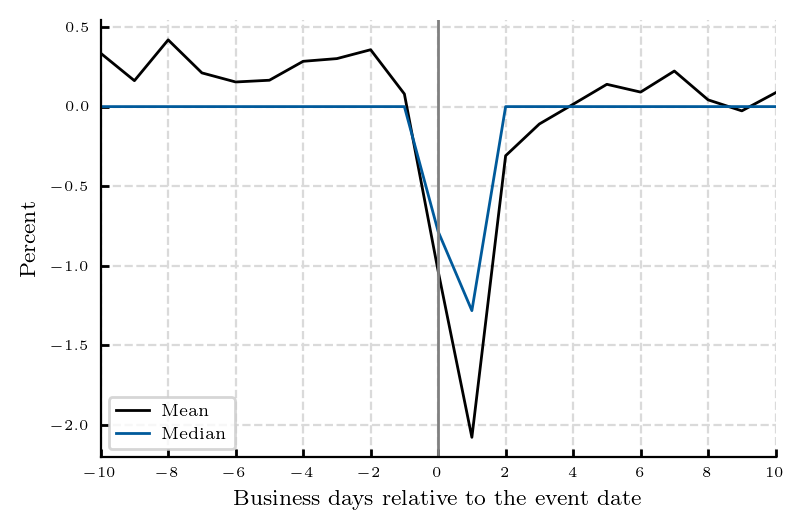

In [58]:
Fig, ax = EventPlot_Lines(tempstat['F_Ret'].loc[-10:10], {vv: LineDict[vv] for vv in ['mean', '50%']})

In [63]:
TempInd = (TempDS['ShelfIssueFlag'] == 0) & (TempDS['GapBusDays_F2L'] < 1) & (TempDS['GapBusDays_L2I'] > 5)
tempstat = TempDS.loc[TempInd, :].groupby('RelDate')[['F_Ret', 'L_Ret', 'I_Ret']].apply(KeyRetStat).unstack(level=1)

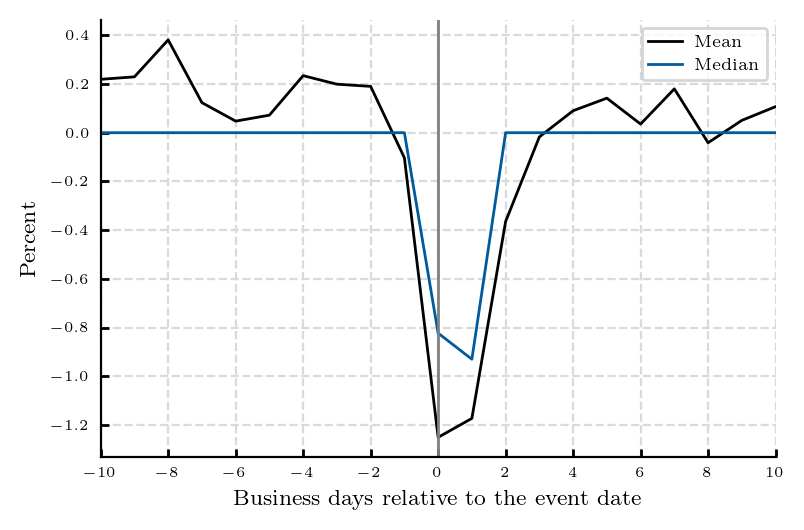

In [64]:
Fig, ax = EventPlot_Lines(tempstat['F_Ret'].loc[-10:10], {vv: LineDict[vv] for vv in ['mean', '50%']})

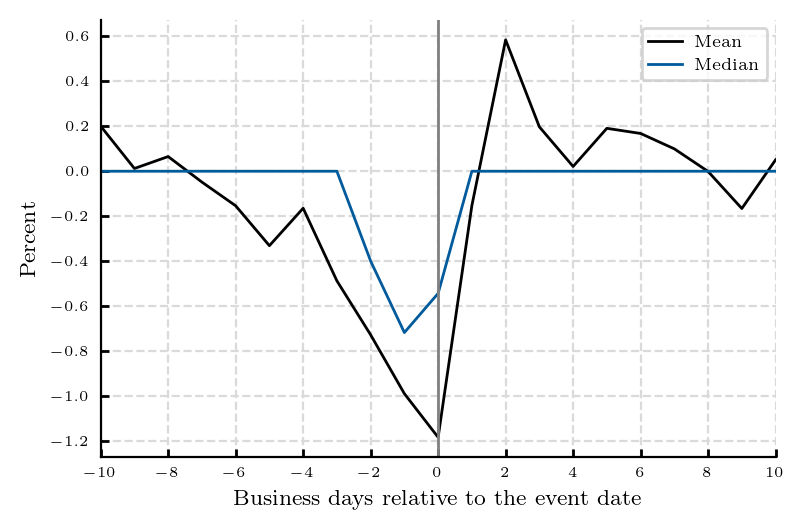

In [65]:
Fig, ax = EventPlot_Lines(tempstat['I_Ret'].loc[-10:10], {vv: LineDict[vv] for vv in ['mean', '50%']})

In [41]:
TempInd = (TempDS['ShelfIssueFlag'] == 0) & (TempDS['GapBusDays_F2L'] >= 1)
tempstat = TempDS.loc[TempInd, :].groupby('RelDate')[['F_Ret', 'L_Ret']].apply(KeyRetStat).unstack(level=1)

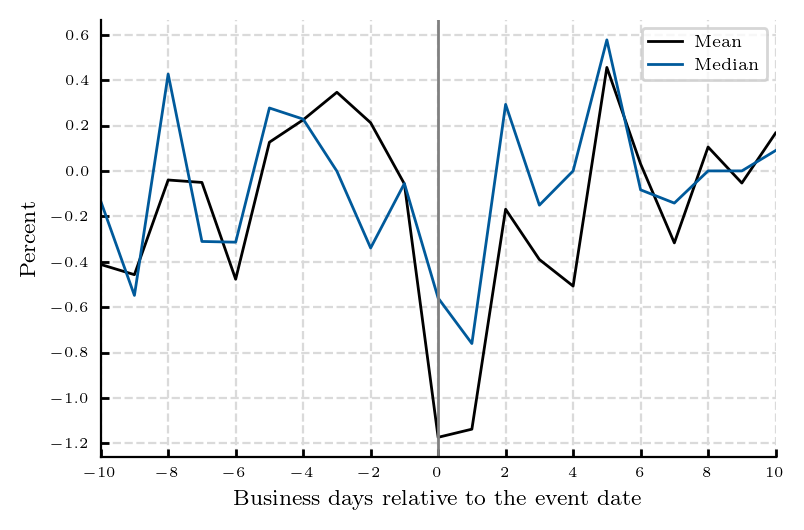

In [42]:
Fig, ax = EventPlot_Lines(tempstat['F_Ret'].loc[-10:10], {vv: LineDict[vv] for vv in ['mean', '50%']})

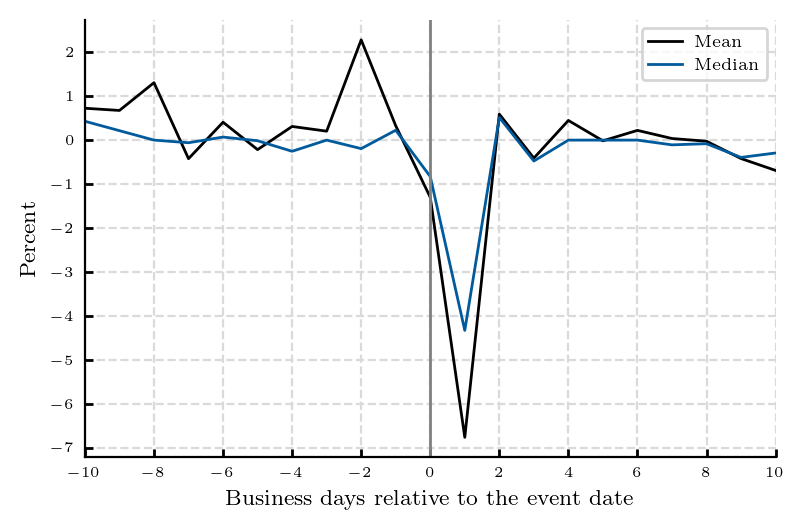

In [43]:
Fig, ax = EventPlot_Lines(tempstat['L_Ret'].loc[-10:10], {vv: LineDict[vv] for vv in ['mean', '50%']})

##### Issue Date

In [44]:
TempInd = (TempDS['ShelfIssueFlag'] == 0) & (TempDS['GapBusDays_F2L'] >= 1) & (TempDS['GapBusDays_L2I'] >=2)
tempstat = TempDS.loc[TempInd, :].groupby('RelDate')[['F_Ret', 'L_Ret', 'I_Ret']].apply(KeyRetStat).unstack(level=1)

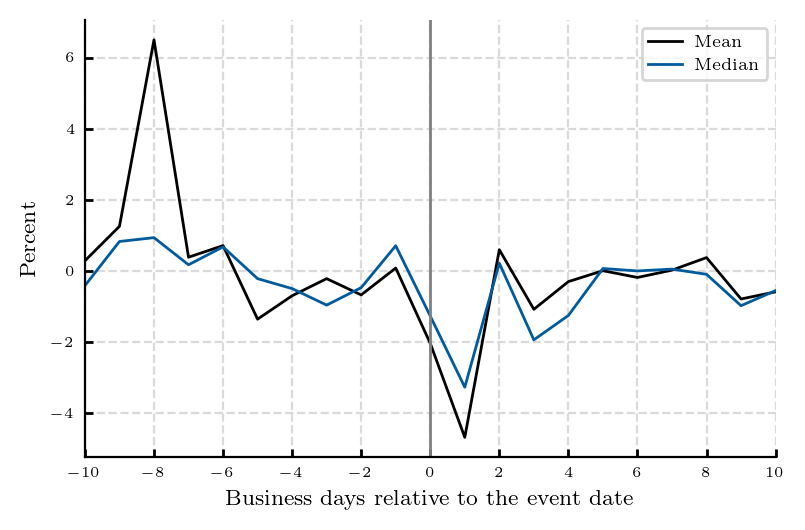

In [45]:
Fig, ax = EventPlot_Lines(tempstat['L_Ret'].loc[-10:10], {vv: LineDict[vv] for vv in ['mean', '50%']})

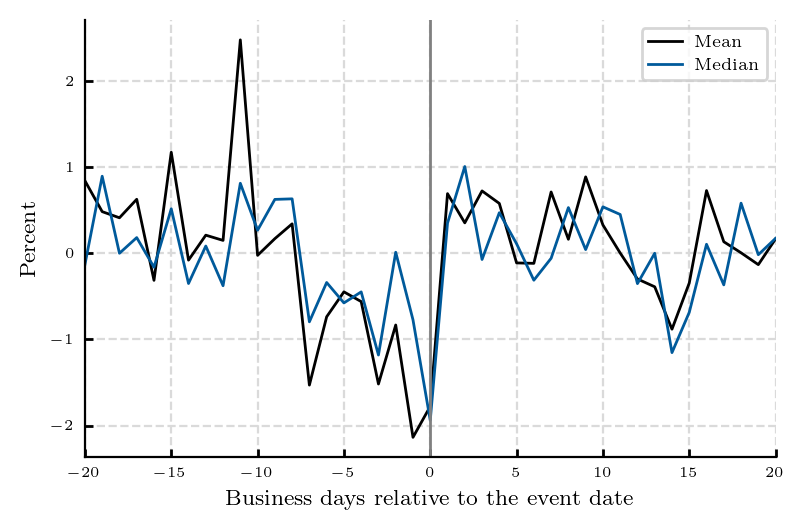

In [46]:
Fig, ax = EventPlot_Lines(tempstat['I_Ret'].loc[-20:20], {vv: LineDict[vv] for vv in ['mean', '50%']})

Takeaway:

For the non-shelf-registered issuance with gap between filing and launching larger than 1 day, the price drop is not significant on filing date, but on launch date.

#### Shelf-registered issuance

##### Filing vs. Launch

In [48]:
TempInd = (TempDS['ShelfIssueFlag'] == 0) & (TempDS['GapBusDays_F2L'] >= 1) 
tempstat = TempDS.loc[TempInd, :].groupby('RelDate')[['F_Ret', 'L_Ret', 'I_Ret']].apply(KeyRetStat).unstack(level=1)

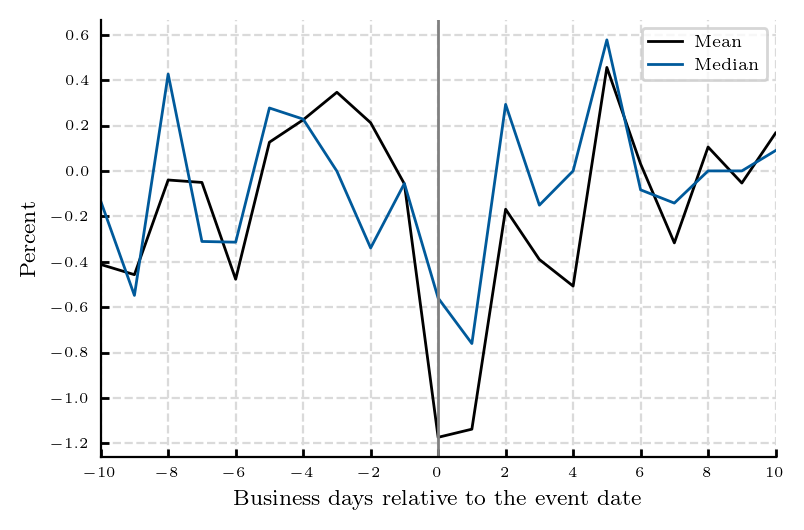

In [49]:
Fig, ax = EventPlot_Lines(tempstat['F_Ret'].loc[-10:10], {vv: LineDict[vv] for vv in ['mean', '50%']})

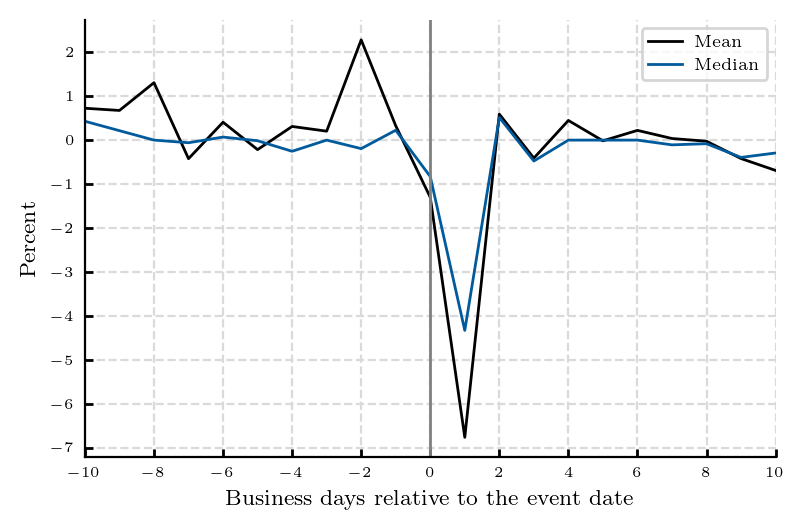

In [50]:
Fig, ax = EventPlot_Lines(tempstat['L_Ret'].loc[-10:10], {vv: LineDict[vv] for vv in ['mean', '50%']})

##### Launch vs. Issue

In [54]:
TempInd = (TempDS['ShelfIssueFlag'] == 0) & (TempDS['GapBusDays_F2L'] >= 1) & (TempDS['GapBusDays_L2I'] >= 2) 
tempstat = TempDS.loc[TempInd, :].groupby('RelDate')[['F_Ret', 'L_Ret', 'I_Ret']].apply(KeyRetStat).unstack(level=1)

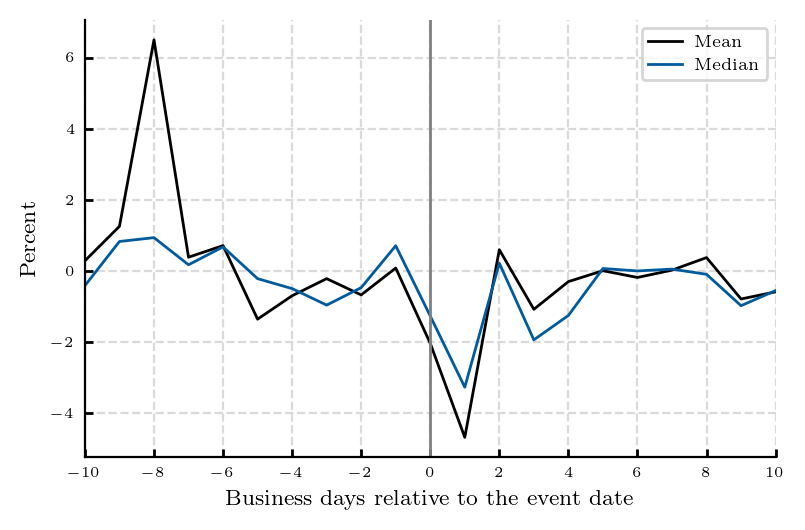

In [55]:
Fig, ax = EventPlot_Lines(tempstat['L_Ret'].loc[-10:10], {vv: LineDict[vv] for vv in ['mean', '50%']})

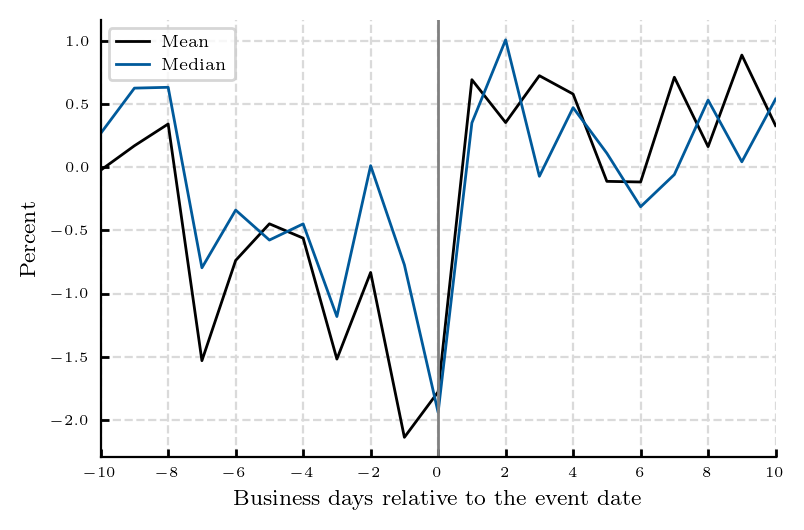

In [56]:
Fig, ax = EventPlot_Lines(tempstat['I_Ret'].loc[-10:10], {vv: LineDict[vv] for vv in ['mean', '50%']})

Thoughts:

1. It might be useful to use the stock price change during the whole period of equity issuance as the model counterpart of "stock price adjustment" associated with the stock issuance event. The stock price on issuance date is the actual price for firms to issue equity.

2. It might be the case that for a particular issuance, one of the event account for most part of the overall price drop, but this type of accounting will not miss any price change that matters for the cost of issuing equity.

3. How to call a relevant measurement window?
    * For non-shelf-registered issuance, 

### Regression event study

In [29]:
TempDS, TempStat = GenRetPanel('FF5_PreEvent')

In [23]:
TempDS 

,IssueID,ShelfIssueFlag,GapBusDays_F2I,GapBusDays_L2I,GapBusDays_F2L,RelDate,F_Ret,F_AbRet,L_Ret,L_AbRet,...,F_AccRet,F_AccAbRet,L_AccRet,L_AccAbRet,I_AccRet,I_AccAbRet,Ret,AbRet,AccRet,AccAbRet
0,694454__19841011_19850128,0.0,77.0,77.0,0.0,-160.0,NaN,<NA>,NaN,<NA>,...,NaN,<NA>,NaN,<NA>,0.160343,-0.014038,NaN,<NA>,NaN,<NA>
1,694454__19841011_19850128,0.0,77.0,77.0,0.0,-159.0,NaN,<NA>,NaN,<NA>,...,NaN,<NA>,NaN,<NA>,0.160343,-0.009358,NaN,<NA>,NaN,<NA>
2,694454__19841011_19850128,0.0,77.0,77.0,0.0,-158.0,NaN,<NA>,NaN,<NA>,...,NaN,<NA>,NaN,<NA>,0.160343,0.005018,NaN,<NA>,NaN,<NA>
3,694454__19841011_19850128,0.0,77.0,77.0,0.0,-157.0,NaN,<NA>,NaN,<NA>,...,NaN,<NA>,NaN,<NA>,0.160343,0.006374,NaN,<NA>,NaN,<NA>
4,694454__19841011_19850128,0.0,77.0,77.0,0.0,-156.0,NaN,<NA>,NaN,<NA>,...,NaN,<NA>,NaN,<NA>,0.160343,0.006529,NaN,<NA>,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115865,56400P_70_20181219_20181219,0.0,0.0,0.0,0.0,3.0,0.000000,-0.005779,0.000000,-0.005779,...,-0.420640,-0.381676,-0.420640,-0.381676,-0.420640,-0.381676,0.000000,-0.005779,-0.420640,-0.381676
1115866,56400P_70_20181219_20181219,0.0,0.0,0.0,0.0,5.0,-0.037388,-0.073646,-0.037388,-0.073646,...,-0.458027,-0.455322,-0.458027,-0.455322,-0.458027,-0.455322,-0.037388,-0.073646,-0.458027,-0.455322
1115867,56400P_70_20181219_20181219,0.0,0.0,0.0,0.0,6.0,-0.028988,-0.033124,-0.028988,-0.033124,...,-0.487015,-0.488446,-0.487015,-0.488446,-0.487015,-0.488446,-0.028988,-0.033124,-0.487015,-0.488446
1115868,56400P_70_20181219_20181219,0.0,0.0,0.0,0.0,7.0,0.115602,0.101401,0.115602,0.101401,...,-0.371413,-0.387045,-0.371413,-0.387045,-0.371413,-0.387045,0.115602,0.101401,-0.371413,-0.387045


In [103]:
RelDateCat = list(TempDS["RelDate"].dropna().unique())
RelDateCat.remove(-1)
RelDateCat = [-1] + RelDateCat


In [104]:

TempDS['RelDateDummy'] = pd.Categorical(TempDS["RelDate"], categories=RelDateCat, ordered=True)
# df["RelDate"] = df["RelDate"].cat.reorder_categories([0, 1, 2, 3], ordered=False)
# 

In [141]:
TempDS['Flag_PreEvent'] = TempDS['RelDate'] < 0
TempDS['Flag_PostEvent'] = TempDS['RelDate'] > 0
TempDS['RelDate_PreEvent'] = TempDS['RelDate'] * (TempDS['RelDate'] < -1) * 1 
TempDS['RelDate_PostEvent'] = TempDS['RelDate'] * (TempDS['RelDate'] > 0) * 1 


In [142]:
TempDS.loc[TempDS['RelDate']==-160, ['IssueID', 'AccRet']].rename(columns={'AccRet': 'Runup'}).set_index('IssueID').head(10)

,Runup
IssueID,
694454__19841011_19850128,NaN
234050__19850129_19850204,-0.460815
285410__19841221_19850208,1.155771
043413__19850211_19850228,0.060625
641217__19850305_19850307,-0.405465
368710__19850301_19850315,-0.540384
462030__19850305_19850403,-0.762827
717265__19850312_19850403,-0.250356
284420__19850325_19850417,0.100805


In [143]:
TempDS 

,IssueID,ShelfIssueFlag,GapBusDays_F2I,GapBusDays_L2I,GapBusDays_F2L,RelDate,F_Ret,F_AbRet,L_Ret,L_AbRet,...,I_AccAbRet,Ret,AbRet,AccRet,AccAbRet,RelDateDummy,RelDate_PreEvent,RelDate_PostEvent,Flag_PreEvent,Flag_PostEvent
0,694454__19841011_19850128,0.0,77.0,77.0,0.0,-160.0,NaN,<NA>,NaN,<NA>,...,-0.014038,NaN,<NA>,NaN,<NA>,-160.0,-160.0,-0.0,True,False
1,694454__19841011_19850128,0.0,77.0,77.0,0.0,-159.0,NaN,<NA>,NaN,<NA>,...,-0.009358,NaN,<NA>,NaN,<NA>,-159.0,-159.0,-0.0,True,False
2,694454__19841011_19850128,0.0,77.0,77.0,0.0,-158.0,NaN,<NA>,NaN,<NA>,...,0.005018,NaN,<NA>,NaN,<NA>,-158.0,-158.0,-0.0,True,False
3,694454__19841011_19850128,0.0,77.0,77.0,0.0,-157.0,NaN,<NA>,NaN,<NA>,...,0.006374,NaN,<NA>,NaN,<NA>,-157.0,-157.0,-0.0,True,False
4,694454__19841011_19850128,0.0,77.0,77.0,0.0,-156.0,NaN,<NA>,NaN,<NA>,...,0.006529,NaN,<NA>,NaN,<NA>,-156.0,-156.0,-0.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115865,56400P_70_20181219_20181219,0.0,0.0,0.0,0.0,3.0,0.000000,-0.005779,0.000000,-0.005779,...,-0.381676,0.000000,-0.005779,-0.420640,-0.381676,3.0,0.0,3.0,False,True
1115866,56400P_70_20181219_20181219,0.0,0.0,0.0,0.0,5.0,-0.037388,-0.073646,-0.037388,-0.073646,...,-0.455322,-0.037388,-0.073646,-0.458027,-0.455322,5.0,0.0,5.0,False,True
1115867,56400P_70_20181219_20181219,0.0,0.0,0.0,0.0,6.0,-0.028988,-0.033124,-0.028988,-0.033124,...,-0.488446,-0.028988,-0.033124,-0.487015,-0.488446,6.0,0.0,6.0,False,True
1115868,56400P_70_20181219_20181219,0.0,0.0,0.0,0.0,7.0,0.115602,0.101401,0.115602,0.101401,...,-0.387045,0.115602,0.101401,-0.371413,-0.387045,7.0,0.0,7.0,False,True


In [169]:
TempDS['ID'] = pd.Categorical(TempDS['IssueID'], ordered=False)

In [170]:

fit = pf.feols("Ret ~ C(RelDateDummy) | ID^Flag_PreEvent", data=TempDS)


KeyError: "None of [Index(['ID^Flag_PreEvent'], dtype='object')] are in the [columns]"

In [ ]:
fit.summary()

###

Estimation:  OLS
Dep. var.: Ret, Fixed effects: IssueID
Inference:  CRV1
Observations:  1068525

| Coefficient               |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| C(RelDateDummy)[T.-160.0] |      0.000 |        0.001 |     0.316 |      0.752 | -0.002 |   0.003 |
| C(RelDateDummy)[T.-159.0] |      0.000 |        0.001 |     0.236 |      0.814 | -0.002 |   0.003 |
| C(RelDateDummy)[T.-158.0] |     -0.001 |        0.001 |    -0.776 |      0.438 | -0.004 |   0.002 |
| C(RelDateDummy)[T.-157.0] |      0.001 |        0.002 |     0.510 |      0.610 | -0.003 |   0.004 |
| C(RelDateDummy)[T.-156.0] |     -0.000 |        0.001 |    -0.013 |      0.990 | -0.003 |   0.003 |
| C(RelDateDummy)[T.-155.0] |      0.001 |        0.001 |     0.762 |      0.446 | -0.002 |   0.003 |
| C(RelDateDummy)[T.-154.0] |     -0.000 |        0.002 |    -0.279 |      0.780 |

In [ ]:
RegRawResult = pd.concat([fit.coef(), fit.confint(0.05)], axis=1)
IdxSet = []
CatSet = []
for cc in TempDS['RelDateDummy'].cat.categories:
    tempvar = 'C(RelDateDummy)[T.'+str(cc)+']'
    if tempvar in RegRawResult.index:
        IdxSet.append(tempvar)
        CatSet.append(int(cc))
RegResult = RegRawResult.loc[IdxSet, :]
RegResult.index = CatSet

if -1 not in RegResult.index:
    RegResult.loc[-1, :] = [0, 0, 0]


In [ ]:
RegResult.index 

Index([-160, -159, -158, -157, -156, -155, -154, -153, -152, -151,
       ...
        153,  154,  155,  156,  157,  158,  159,  160, -148,   -1],
      dtype='int64', length=321)

In [ ]:
RegResult

,Estimate,2.5%,97.5%
-160,0.000448,-0.002336,0.003232
-159,0.000308,-0.002249,0.002865
-158,-0.001039,-0.003663,0.001585
-157,0.000890,-0.002532,0.004311
-156,-0.000018,-0.002732,0.002696
...,...,...,...
158,-0.000663,-0.003187,0.001860
159,0.000225,-0.002287,0.002737
160,-0.000138,-0.002747,0.002471
-148,-0.000018,-0.002667,0.002631


<Axes: >

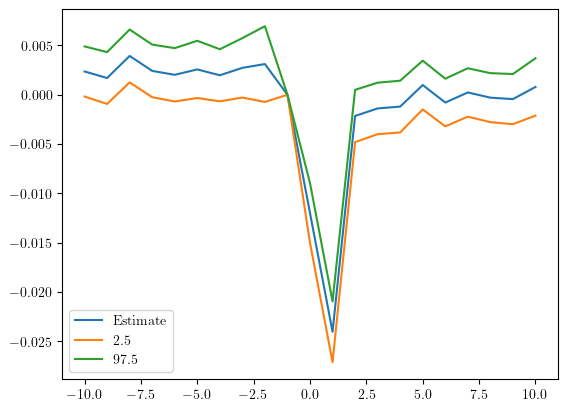

In [ ]:
RegResult.sort_index().loc[-10:10,: ].plot() 